In [1]:
!pip install --upgrade diffusers transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.9 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [5]:
pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token='your_hugging_face_auth_token', guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token', 'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image

  0%|          | 0/35 [00:00<?, ?it/s]

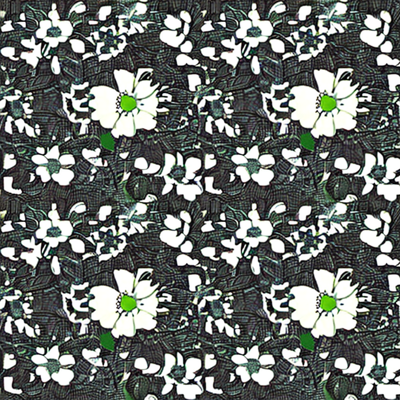

In [8]:
generate_image("flower", image_gen_model)